In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile, generate_random_pos
from utils.download_data.h2f_download_functions import get_galaxy_img

In [13]:
data_pasquet = np.load(f"../data/SERSIC/X_train_pasquet_balanced_like_delight_augmented_dataset_01_percent.npz")
pos_pasquet = data_pasquet['pos']

del data_pasquet

data_pasquet2 = np.load(f"../data/SERSIC/X_train_pasquet_balanced_like_delight_augmented_dataset_01_percent_2.npz")
pos_pasquet2 = data_pasquet2['pos']

del data_pasquet2

data_pasquet5 = np.load(f"../data/SERSIC/X_train_pasquet_balanced_like_delight_x5_augmented_dataset_01_percent.npz")
pos_pasquet5 = data_pasquet5['pos']

del data_pasquet5

data_aug_delight = np.load(f"../data/SERSIC/X_train_augmented_dataset_01_percent.npz")
pos_aug_delight = data_aug_delight['pos']

del data_aug_delight

data_aug_delight05 = np.load(f"../data/SERSIC/X_train_augmented_dataset_05_percent.npz")
pos_aug_delight05 = data_aug_delight05['pos']

del data_aug_delight05

In [14]:
dist_pasquet = np.linalg.norm(pos_pasquet, axis=1)
dist_pasquet2 = np.linalg.norm(pos_pasquet2, axis=1)
dist_pasquet5 = np.linalg.norm(pos_pasquet5, axis=1)

dist_aug_delight = np.linalg.norm(pos_aug_delight, axis=1)
dist_aug_delight05 = np.linalg.norm(pos_aug_delight05, axis=1)

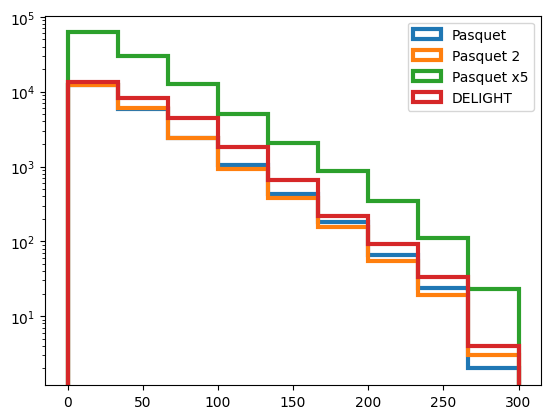

In [ ]:
bins = np.linspace(0,300,10)
plt.hist(dist_pasquet,bins=bins, histtype="step", linewidth=3, label="Pasquet")
plt.hist(dist_pasquet2,bins=bins, histtype="step", linewidth=3, label="Pasquet 2")
plt.hist(dist_pasquet5,bins=bins, histtype="step", linewidth=3, label="Pasquet x5")

plt.hist(dist_aug_delight,bins=bins, histtype="step", linewidth=3, label="DELIGHT")
plt.hist(dist_aug_delight,bins=bins, histtype="step", linewidth=3, label="DELIGHT")

plt.yscale("log")
plt.legend()
plt.show()

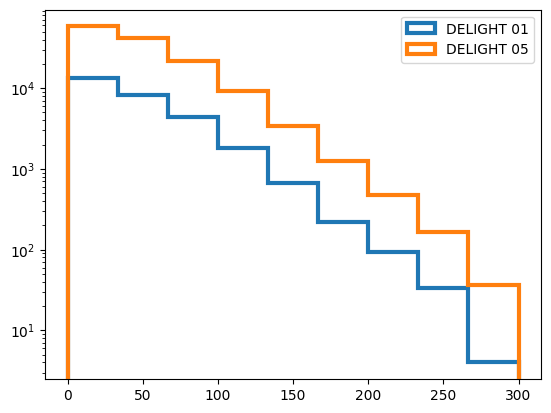

In [16]:
plt.hist(dist_aug_delight,bins=bins, histtype="step", linewidth=3, label="DELIGHT 01")
plt.hist(dist_aug_delight05,bins=bins, histtype="step", linewidth=3, label="DELIGHT 05")

plt.yscale("log")
plt.legend()
plt.show()

In [2]:
from joblib import Parallel, delayed

def augment_dataframe(data_frame, n_jobs=-1):
    """
    Duplica filas de un DataFrame según el número de augmentaciones calculado
    con un perfil de Sérsic.
    """
    def compute_num_aug(row):
        sersic_img = sersic_profile(
            image_shape=(600, 600),
            x_center=299, y_center=299,
            Re_arcsec=row["rSerRadius"],
            b_over_a=row["rSerAb"],
            theta_deg=row["rSerPhi"],
            pixel_scale=0.25,
            Ie=1.0,
            n=4
        )
        n_pix = np.count_nonzero(sersic_img) * 0.001
        return int(np.ceil(n_pix))

    nums = Parallel(n_jobs=n_jobs)(
        delayed(compute_num_aug)(row) for _, row in data_frame.iterrows()
    )
    data_frame = data_frame.copy()
    data_frame["num_augmentations"] = nums

    data_frame_aug = data_frame.loc[
       data_frame.index.repeat(data_frame["num_augmentations"])
    ].reset_index(drop=True)

    return data_frame_aug


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/SERSIC/df_train_clean.csv")
df_pasquet = pd.read_csv("../data/SERSIC/df_pasquet_sersic.csv")

/tmp/ipykernel_4153424/216057034.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pasquet.groupby("bin", group_keys=False)
/tmp/ipykernel_4153424/216057034.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), 1*bin_counts_df.get(g.name, 0)), random_state=48))


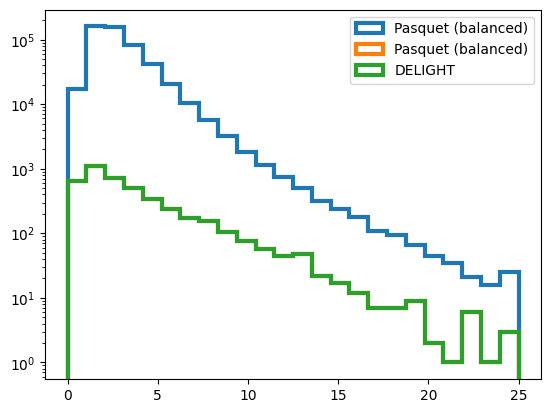

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Definir los bins ---
bins = np.linspace(0, 25, 25)

# --- 2. Asignar cada muestra a un bin ---
df["bin"] = pd.cut(df["rSerRadius"], bins=bins, include_lowest=True)
df_pasquet["bin"] = pd.cut(df_pasquet["rSerRadius"], bins=bins, include_lowest=True)

# --- 3. Contar cuántas muestras tiene df en cada bin ---
bin_counts_df = df["bin"].value_counts(sort=False)

# --- 4. Submuestrear df_pasquet para igualar el conteo de df ---
df_pasquet_balanced5 = (
    df_pasquet.groupby("bin", group_keys=False)
    .apply(lambda g: g.sample(n=min(len(g), 1*bin_counts_df.get(g.name, 0)), random_state=48))
)

# --- 5. Graficar ---
plt.hist(df_pasquet["rSerRadius"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced)")

plt.hist(df_pasquet_balanced5["rSerRadius"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced)")
plt.hist(df["rSerRadius"], bins=bins, histtype="step", linewidth=3, label="DELIGHT")

plt.yscale("log")
plt.legend()
plt.show()


In [4]:
df_pasquet_balanced5 = df_pasquet_balanced5.drop(["bin"], axis=1)

In [5]:
df_pasquet_balanced5.to_csv("../data/SERSIC/df_pasquet_balanced_like_delight_sersic_2.csv", index=False)

In [7]:
df_pasquet_balanced5.shape

(4315, 9)

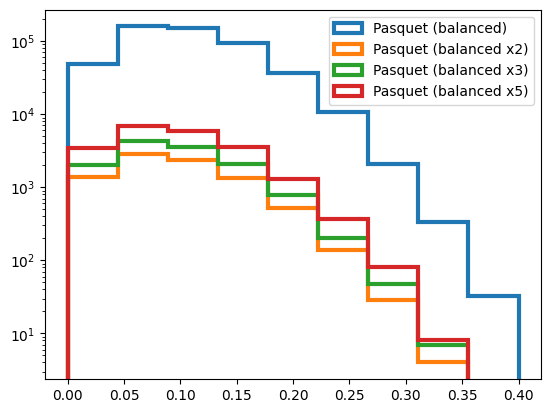

In [24]:
bins = np.linspace(0,0.4,10)
plt.hist(df_pasquet["z"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced)")
plt.hist(df_pasquet_balanced2["z"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced x2)")

plt.hist(df_pasquet_balanced["z"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced x3)")
plt.hist(df_pasquet_balanced5["z"], bins=bins, histtype="step", linewidth=3, label="Pasquet (balanced x5)")

plt.yscale("log")
plt.legend()
plt.show()

In [12]:
df_pasquet_balanced = df_pasquet_balanced.drop(['bin'], axis=1)

In [15]:
df_pasquet_balanced.to_csv("../data/SERSIC/df_pasquet_balanced_like_delight_sersic.csv", index=False)

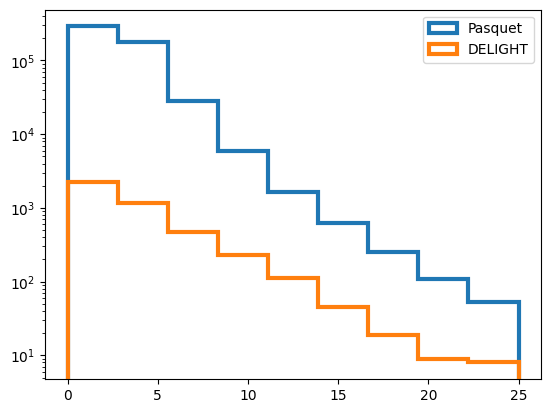

In [4]:
bins = np.linspace(0,25,10)
plt.hist(df_pasquet.rSerRadius,bins=bins, histtype="step", linewidth=3, label="Pasquet")
plt.hist(df.rSerRadius,bins=bins, histtype="step", linewidth=3, label="DELIGHT")


plt.yscale("log")
plt.legend()
plt.show()

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Separar regiones ---
limite = 12.5
df_low = df_pasquet[df_pasquet["rSerRadius"] <= limite].copy()
df_high = df_pasquet[df_pasquet["rSerRadius"] > limite].copy()

# --- 2. Definir bins solo hasta el límite ---
bins = np.linspace(0, limite, 10)
df_low["bin"] = pd.cut(df_low["rSerRadius"], bins=bins, include_lowest=True)

# --- 3. Contar muestras por bin ---
bin_counts = df_low["bin"].value_counts(sort=False)
n_bins = len(bin_counts)

# --- 4. Definir fracción exponencial (recortando hacia radios bajos) ---
i = np.arange(n_bins)
fractions = np.exp(i / (n_bins - 1) * 2)  # controla pendiente (2 = moderado)
fractions /= fractions.max()               # normaliza a [0,1]

# --- 5. Aplicar muestreo a df_low ---
df_low_bal = pd.concat([
    g.sample(frac=f, random_state=42) if len(g) > 0 else g
    for (_, g), f in zip(df_low.groupby("bin"), fractions)
])

# --- 6. Combinar con la parte alta (sin muestrear) ---
df_balanced = pd.concat([df_low_bal, df_high], ignore_index=True)



/tmp/ipykernel_2827946/3859362186.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (_, g), f in zip(df_low.groupby("bin"), fractions)


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Definir bins ---
bins = np.linspace(0, 25, 10)
df_pasquet["bin"] = pd.cut(df_pasquet["rSerRadius"], bins=bins, include_lowest=True)

# --- 2. Contar muestras por bin ---
bin_counts = df_pasquet["bin"].value_counts(sort=False)
n_bins = len(bin_counts)

# --- 3. Definir fracción exponencial creciente desde el último bin ---
i = np.arange(n_bins)
# Crecimiento exponencial: pequeño al inicio, 1.0 al final
fractions = np.exp(i / (n_bins - 1) * 2)  # 3 controla la pendiente
fractions /= fractions.max()               # normalizamos a [0,1]
# Ahora el primer bin tendrá menos muestras y el último todas

# --- 4. Aplicar muestreo por bin ---
df_balanced = pd.concat([
    g.sample(frac=f, random_state=0) if len(g) > 0 else g
    for (_, g), f in zip(df_pasquet.groupby("bin"), fractions)
])


/tmp/ipykernel_2827946/2218291284.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (_, g), f in zip(df_pasquet.groupby("bin"), fractions)


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Separar regiones ---
limite = 12.5
df_low = df_pasquet[df_pasquet["rSerRadius"] <= limite].copy()
df_high = df_pasquet[df_pasquet["rSerRadius"] > limite].copy()

# --- 2. Definir bins solo hasta el límite ---
bins = np.linspace(0, limite, 10)
df_low["bin"] = pd.cut(df_low["rSerRadius"], bins=bins, include_lowest=True)

# --- 3. Contar muestras por bin ---
bin_counts = df_low["bin"].value_counts(sort=False)
n_bins = len(bin_counts)

# --- 4. Definir fracción exponencial (recortando hacia radios bajos) ---
i = np.arange(n_bins)
fractions = np.exp(i / (n_bins - 1) * 5)  # controla pendiente (2 = moderado)
fractions /= fractions.max()               # normaliza a [0,1]

# --- 5. Aplicar muestreo a df_low ---
df_low_bal = pd.concat([
    g.sample(frac=f, random_state=42) if len(g) > 0 else g
    for (_, g), f in zip(df_low.groupby("bin"), fractions)
])

# --- 6. Combinar con la parte alta (sin muestrear) ---
df_balanced = pd.concat([df_low_bal, df_high], ignore_index=True)



/tmp/ipykernel_2827946/1201169385.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (_, g), f in zip(df_low.groupby("bin"), fractions)


In [58]:
df_aug_delight =augment_dataframe(df)

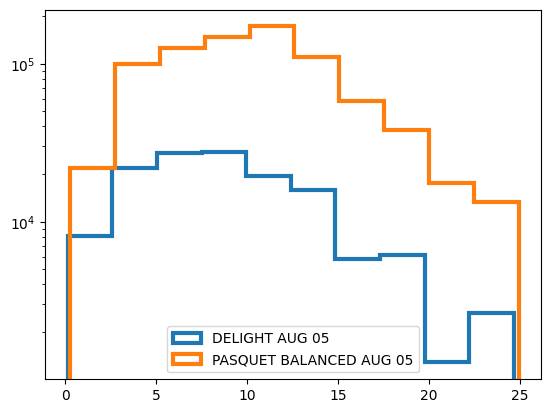

In [59]:
plt.hist(df_aug_delight.rSerRadius, histtype="step", linewidth=3, label="DELIGHT AUG 05")
plt.hist(df_aug.rSerRadius, histtype="step", linewidth=3, label="PASQUET BALANCED AUG 05")


plt.yscale("log")
plt.legend()
plt.show()

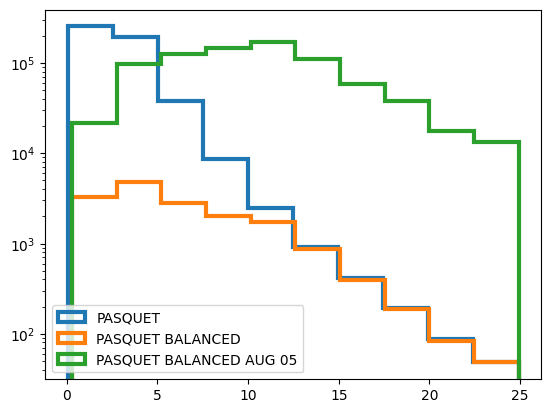

In [57]:
plt.hist(df_pasquet.rSerRadius, histtype="step", linewidth=3, label="PASQUET")
plt.hist(df_balanced.rSerRadius, histtype="step", linewidth=3, label="PASQUET BALANCED")
plt.hist(df_aug.rSerRadius, histtype="step", linewidth=3, label="PASQUET BALANCED AUG 05")



plt.yscale("log")
plt.legend()
plt.show()

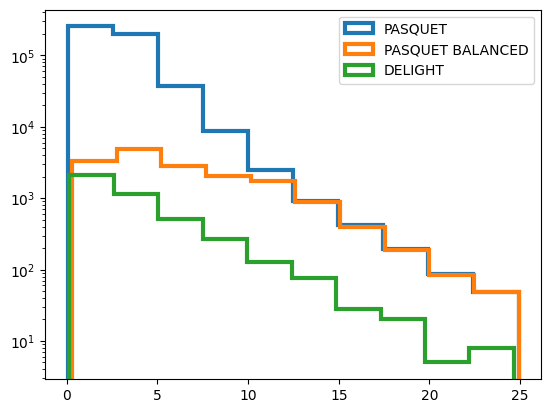

In [62]:
plt.hist(df_pasquet.rSerRadius, histtype="step", linewidth=3, label="PASQUET")
plt.hist(df_balanced.rSerRadius, histtype="step", linewidth=3, label="PASQUET BALANCED")

plt.hist(df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT")


plt.yscale("log")
plt.legend()
plt.show()

In [53]:
df_balanced.shape

(16273, 10)

In [8]:
df.shape

(501835, 10)

In [9]:
df_balanced.shape

(176864, 10)

In [38]:
aug_df_5 = augment_dataframe(df)

In [31]:
aug_df_01 = augment_dataframe(df)

In [26]:
aug_df_pasquet = augment_dataframe(df_pasquet)

In [28]:
aug_df_pasquet.shape

(1695409, 10)

In [20]:
aug_df.shape

(135431, 119)

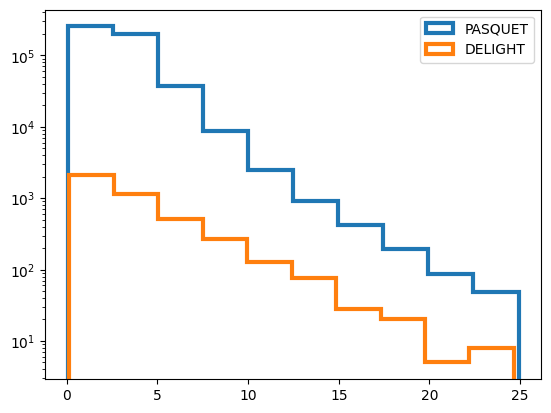

In [45]:
plt.hist(df_pasquet.rSerRadius, histtype="step", linewidth=3, label="PASQUET")

plt.hist(df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT")


plt.yscale("log")
plt.legend()
plt.show()

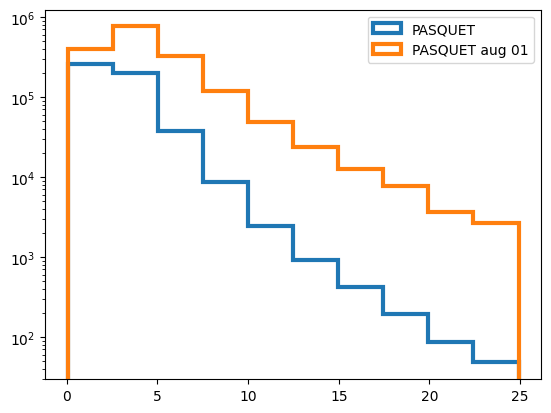

In [43]:
plt.hist(df_pasquet.rSerRadius, histtype="step", linewidth=3, label="PASQUET")

plt.hist(aug_df_pasquet.rSerRadius, histtype="step", linewidth=3, label="PASQUET aug 01")


plt.yscale("log")
plt.legend()
plt.show()

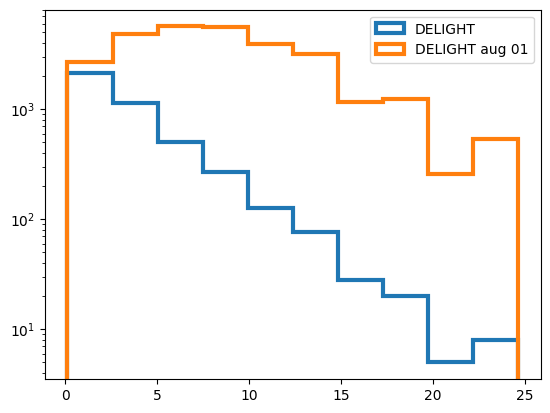

In [ ]:
plt.hist(df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT")

plt.hist(aug_df_01.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug 01")


plt.yscale("log")
plt.legend()
plt.show()

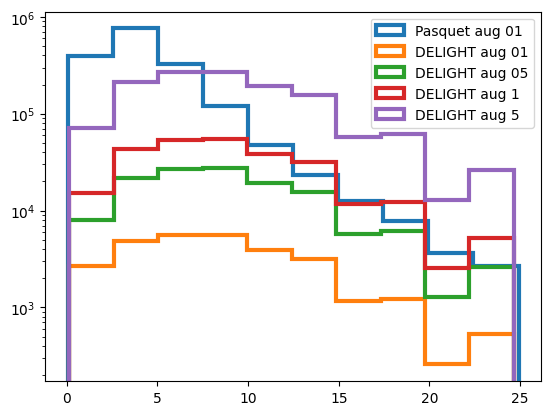

In [40]:
plt.hist(aug_df_pasquet.rSerRadius, histtype="step", linewidth=3, label="Pasquet aug 01")

plt.hist(aug_df_01.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug 01")

plt.hist(aug_df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug 05")
plt.hist(aug_df_1.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug 1")
plt.hist(aug_df_5.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug 5")


plt.yscale("log")
plt.legend()
plt.show()

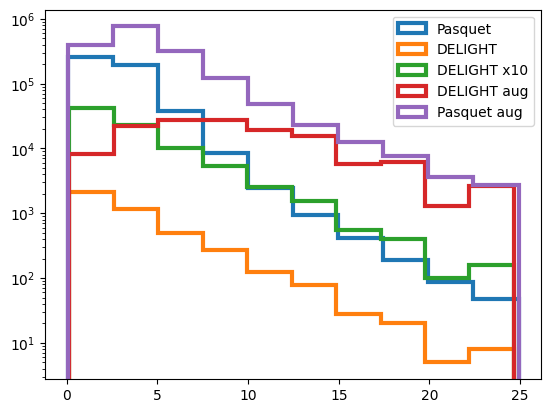

In [30]:
plt.hist(df_pasquet.rSerRadius, histtype="step", linewidth=3, label="Pasquet")
plt.hist(df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT")
plt.hist(np.tile(df.rSerRadius.values, 20), histtype="step", linewidth=3, label="DELIGHT x10")
plt.hist(aug_df.rSerRadius, histtype="step", linewidth=3, label="DELIGHT aug")
plt.hist(aug_df_pasquet.rSerRadius, histtype="step", linewidth=3, label="Pasquet aug")

plt.yscale("log")
plt.legend()
plt.show()

In [6]:
df_pasquet.rSerRadius

0         3.75879
1         2.30334
2         2.53094
3         4.18844
4         3.82143
           ...   
501830    1.95050
501831    3.48583
501832    2.26532
501833    2.90271
501834    3.74872
Name: rSerRadius, Length: 501835, dtype: float64

In [ ]:
df = pd.read_csv("../data/SERSIC/df_train_clean.csv")
#df = pd.read_csv("../data/SERSIC/df_pasquet_sersic_01_percent.csv")
#df = pd.read_csv("../data/SERSIC/df_train_clean_2_percent.csv")

### EDA

In [ ]:
# Radio de las elipses de Sersic (3 veces el radio) en pixeles
# En este caso seleccionamos 210 pixeles de radio

print(df["rSerRadius"].max()*3/0.25)
print(df["rSerRadius"].median()*3/0.25)
print(df["rSerRadius"].mean()*3/0.25)
print(df["rSerRadius"].std()*3/0.25)

data = df["rSerRadius"] * 3 / 0.25

# Definir bines logarítmicos desde 1 a 1000 (puedes ajustar la cantidad de bines)
bins = np.logspace(np.log10(1), np.log10(1000), num=20)

plt.hist(data, bins=np.linspace(0,300,30), histtype="step", linewidth=1.5)


#plt.xscale("log")
plt.yscale("log")
plt.xlabel("Major Axis [pix]")
plt.ylabel("Frecuencia")
plt.show()

### Funciones

In [ ]:
def plot_galaxy_and_sersic(df, idx, Ie=1.0, n=4):
    """
    Visualiza una galaxia con su perfil radial, su perfil de Sérsic y distribuciones de posiciones 
    aleatorias de supernovas simuladas.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con parámetros de galaxias y supernovas. Debe contener 
        las columnas: 
        - 'host_ra', 'host_dec' (coordenadas en grados, usadas en `get_sdss_img`)
        - 'rSerRadius' (radio efectivo en arcsec)
        - 'rSerAb' (relación de ejes b/a)
        - 'rSerPhi' (ángulo de posición en grados)
        - 'dx', 'dy' (desplazamiento en píxeles de la supernova respecto al centro).
    idx : int
        Índice de la fila en el DataFrame correspondiente a la galaxia a visualizar.
    Ie : float, optional
        Intensidad central del perfil de Sérsic. Default es 1.0.
    n : int, optional
        Índice de Sérsic (concentración del perfil). Default es 4 (perfil de de Vaucouleurs).

    Returns
    -------
    sersic_img : np.ndarray
        Imagen 2D con el perfil de Sérsic generado para la galaxia.
    random_pos : np.ndarray
        Arreglo de forma (1000, 2) con posiciones aleatorias simuladas de supernovas 
        dentro del perfil de Sérsic, centradas en el núcleo de la galaxia.

    Notes
    -----
    - La primera figura muestra la galaxia real con el perfil elíptico y 
      la posición de la supernova observada.
    - La segunda figura muestra el perfil de Sérsic simulado.
    - La tercera figura muestra un mapa de calor con las posiciones simuladas 
      de la supernova en 1000 iteraciones.
    """
    row = df.iloc[idx]
    image_data = get_galaxy_img(df, idx, level=0, size=240) #Imagen de 240x240 con resolucion 0.25 arcsec/pix

    # Coordenadas del centro
    x_center, y_center = image_data.shape[0]//2 -1 , image_data.shape[1]//2 -1

    # Parámetros de Sérsic
    Re_arcsec = row["rSerRadius"]
    b_over_a = row["rSerAb"]
    theta_sersic = row["rSerPhi"]  # Usar el ángulo original
    pixel_scale = 0.25
    Re_pix = Re_arcsec / pixel_scale
    A_pix = Re_pix
    B_pix = A_pix * b_over_a

    # Generar perfil de Sérsic
    sersic_img = sersic_profile(
        image_shape=image_data.shape,
        x_center=x_center, y_center=y_center,
        Re_arcsec=Re_arcsec,
        b_over_a=b_over_a,
        theta_deg=theta_sersic,  
        pixel_scale=pixel_scale,
        Ie=Ie,
        n=n
    )

    # vemos las posiciones que tomo la supernova en 1000 iteraciones
    random_pos = []
    for _ in range(2):
        pos = generate_random_pos(sersic_radius = Re_arcsec, 
                                    sersic_ab = b_over_a, 
                                    sersic_phi = theta_sersic, 
                                    img_size = image_data.shape[0])
        random_pos.append(pos) 

    random_pos =  np.array(random_pos) + x_center
    x_iter = random_pos[:, 0]
    y_iter = random_pos[:, 1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

    dx, dy = row[["dx","dy"]].values

    x_star = x_center + dx
    y_star = y_center + dy

    # Imagen real con elipse
    ax1 = axes[0]

    # Posicion SN real
    ax1.scatter(x_star, y_star,
                marker='*',         
                color='yellow',     
                s=500,              
                edgecolor='black')  
    
    ax1.imshow(image_data, cmap='gray', origin="lower",
               vmin=np.percentile(image_data, 1),
               vmax=np.percentile(image_data, 99))
    

    for r in [1, 2, 3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax1.add_patch(ellipse)

    ax1.set_title("Galaxia con perfil elíptico")
    ax1.axis('off')

    # Mostrar perfil de Sérsic
    ax2 = axes[1]
    im = ax2.imshow(sersic_img, cmap='viridis', vmin=0, vmax=300, origin="lower")

    # Posciones SN arbitrarias
    for r in [1, 2, 3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=theta_sersic+90,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax2.add_patch(ellipse)

    ax2.set_title("Perfil de Sérsic (n=4)")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, label='Intensidad')

    ax3 = axes[2]
    hist, _, _ = np.histogram2d(x_iter, y_iter, bins=240, range=[[0, 240], [0, 240]])
    im3 = ax3.imshow(hist.T, cmap='hot', interpolation='nearest', origin="lower")
    ax3.set_title('Posiciones supernova 1000 sampleos arbitrarios')
    ax3.axis('off')
    fig.colorbar(im3, ax=ax3, label='Frecuencia')


    plt.tight_layout()
    plt.show()

    return sersic_img, random_pos

### Plots

In [ ]:
for idx in range(1):
    _ = plot_galaxy_and_sersic(df = df, idx = idx) 